In [11]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pandas import DataFrame
from torch import Tensor

DATASET_ID = 0      # 0 = original data, 1 = PCA 100 data, 2 = PCA 80 data
FILENAME_0 = "original_tpm_data.csv"
FILENAME_1 = "pca_data_100.csv"
FILENAME_2 = "pca_data_080.csv"

In [12]:
def load_data(dataset:int): 
    """
    loads data into pd dataFrame. either original or pca

    Args:
        dataset (int): 0 = original data, 1 = PCA 100 data, 2 = PCA 80 data
    """

    # choose dataset according to user input (parameter dataset)
    if dataset==0:
        print("  loading original data")
        data = pd.read_csv(filepath_or_buffer=FILENAME_0)    # this dataset needs to be created locally, using notebook 01. It is too large for git
    elif dataset==1:
        print("  loading pca 100 data")
        data = pd.read_csv(filepath_or_buffer=FILENAME_1)
    elif dataset==2:
        print("  loading pca 80 data")
        data = pd.read_csv(filepath_or_buffer=FILENAME_2)

    # change ctargel col "cancer_type" from string label to int val
    map = {
        "kidney chromophobe": 0,
        "kidney renal clear cell carcinoma": 1,
        "kidney renal papillary cell carcinoma": 2,
    }
    data1 = data.copy()
    data1['cancer_type'] = data1['cancer_type'].replace(map)
    
    return data1

# Step 1 Loading data
print("Step 1: Loading data")

# load anyway
#data = load_data(DATASET_ID)

# load if necessary
try:
    data                 # its ok that this var is not defined 
except NameError:
    data = load_data(DATASET_ID)

data.head()

Step 1: Loading data
  loading original data


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6,cancer_type
0,8.2367,0.0000,25.8092,0.9317,0.2657,2.9539,1.4042,15.7151,4.5194,4.9240,...,0.0000,0.1066,0.0,0.0,0.0,3.6421,0.0,0.0035,0.7835,0
1,4.0204,0.1582,16.6135,0.5691,0.1217,1.4957,0.1268,10.0106,3.0583,2.1101,...,0.0000,0.2003,0.0,0.0,0.0,2.4549,0.0,0.0944,0.4324,0
2,30.3101,0.0000,194.5276,4.1172,4.2266,9.3357,11.7886,63.2781,8.2357,61.3211,...,0.0000,0.5563,0.0,0.0,0.0,10.8131,0.0,0.0336,1.5405,0
3,192.6733,2.2687,166.1158,13.8005,2.6671,9.7596,9.5741,62.3076,7.1604,30.2865,...,0.0000,0.1799,0.0,0.0,0.0,11.7993,0.0,0.2841,0.5695,0
4,29.3118,0.2938,56.6818,1.8314,0.4773,0.5403,0.5084,25.3080,5.7213,5.0955,...,0.5162,0.1739,0.0,0.0,0.0,6.1702,0.0,0.0129,0.1659,0


In [13]:
# Step 3: Define Variables
print("Step 3: Define Variables")

HIDDEN_UNITS = 64
NUM_FEATURES = data.shape[1]-1              # pca=1028 / 200 / orig=60660 # -1 because of target col
NUM_CLASSES = len(data.iloc[:,-1].unique()) # cancer types
DEVICE = "cpu"
LR = 0.0005                                 # learning Rate
EPOCHS = 50
SEED = 42                             # set to None after debugging

loss_fn = nn.CrossEntropyLoss()             # = criterion

def accuracy_fn(y_true, y_logits):
    _, predicted = torch.max(y_logits, 1)# go from logits -> prediction probabilities -> prediction labels
    correct = (predicted == y_true).sum().item()    # if result correct, add to # of correct answers
    accuracy = correct / y_true.size(0)
    return accuracy

print("  HIDDEN_UNITS: ", HIDDEN_UNITS)
print("  NUM_FEATURES: ", NUM_FEATURES)
print("  NUM_CLASSES: ", NUM_CLASSES)
print("  DEVICE: ", DEVICE)
print("  LR: ", LR)
print("  EPOCHS: ", EPOCHS)
print("  SEED: ", SEED)

Step 3: Define Variables
  HIDDEN_UNITS:  64
  NUM_FEATURES:  60660
  NUM_CLASSES:  3
  DEVICE:  cpu
  LR:  0.0005
  EPOCHS:  50
  SEED:  42


In [14]:
def split_data(data: DataFrame, normalize=False, seed:int=None) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    """
    returns Train Test splittet Tensors

    Args:
        data (pd Dataframe): whole dataset

    Returns:
        torch tensor: 4-tuple of train test data
    """

    # Split the data into features (X) and target variable (y)
    X = data.drop('cancer_type', axis=1)
    y = data['cancer_type']

    X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X, y, test_size=0.2, random_state=seed)

    # normalizing data: no effect for pca
    if normalize:
        scaler = StandardScaler()
        X_train_pd = pd.DataFrame(scaler.fit_transform(X_train_pd))
        X_test_pd = pd.DataFrame(scaler.transform(X_test_pd))

    X_train_tens = torch.tensor(X_train_pd.values).float()
    X_test_tens = torch.tensor(X_test_pd.values).float()
    y_train_tens = torch.tensor(y_train_pd.values)
    y_test_tens = torch.tensor(y_test_pd.values)

    return (X_train_tens, X_test_tens, y_train_tens, y_test_tens)

# Step 2 Splitting data & formatting to tensor
print("Step 2: Splitting data & formatting to tensor")

X_train, X_test, y_train, y_test = split_data(data, normalize=True, seed=SEED)

# Print the shapes of the datasets
print("  X_train:", X_train.shape)
print("  X_test:", X_test.shape)
print("  y_train:", y_train.shape)
print("  y_test:", y_test.shape)


Step 2: Splitting data & formatting to tensor


  X_train: torch.Size([822, 60660])
  X_test: torch.Size([206, 60660])
  y_train: torch.Size([822])
  y_test: torch.Size([206])


In [15]:
# Step 4: Define the Neural Network Class
print("Step 4: Define the Neural Network Class")

class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleClassifier, self).__init__() 

        self.non_linear_layer_stack = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Define forward pass
        return self.non_linear_layer_stack(x)
    

# Step 5: Initialize the Neural Network
print("Step 5: Initialize the Neural Network\n")

if SEED:
    torch.manual_seed(SEED)

model = SimpleClassifier(NUM_FEATURES, HIDDEN_UNITS, NUM_CLASSES)
print("Neural Network Architecture:")
print(model)

Step 4: Define the Neural Network Class
Step 5: Initialize the Neural Network

Neural Network Architecture:
SimpleClassifier(
  (non_linear_layer_stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=60660, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=3, bias=True)
    (4): Softmax(dim=1)
  )
)


In [16]:
# Step 6: Define Optimizer
print("Step 6: Define Optimizer")

optimizer = optim.Adam(model.parameters(), lr=LR)
print("optimizer: ", optimizer)

Step 6: Define Optimizer


optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


In [17]:
## model pre testing

def model_pre_testing(DEVICE, NUM_CLASSES, X_test, X_train):
    # Perform a single forward pass on the data 
    print(model(X_train.to(DEVICE))[:5])
    print(model(X_train.to(DEVICE))[0].shape, NUM_CLASSES , "\n")

    # Make prediction logits with model
    y_logits_test = model(X_test.to(DEVICE))

    # Perform softmax calculation on logits across dimension 1 to get prediction probabilities
    y_pred_probs = torch.softmax(y_logits_test, dim=1) 
    print(y_logits_test[:5])
    print(y_pred_probs[:5], "\n")

    # Sum the first sample output of the softmax activation function 
    print(torch.sum(y_pred_probs[0]), "\n")

    # Which class does the model think is *most* likely at the index 0 sample?
    print(y_pred_probs[0])
    print(torch.argmax(y_pred_probs[0]), "\n")

#model_pre_testing(DEVICE, NUM_CLASSES, X_test, X_train)

Step 7: Training the Neural Network with Test Printing
Epoch: 1 | Loss: 1.12256, Acc: 22.02% | Test Loss: 0.76989, Test Acc: 78.16%


Epoch: 2 | Loss: 0.76697, Acc: 78.35% | Test Loss: 0.71546, Test Acc: 82.04%
Epoch: 3 | Loss: 0.71198, Acc: 83.58% | Test Loss: 0.68472, Test Acc: 85.92%
Epoch: 4 | Loss: 0.69404, Acc: 85.28% | Test Loss: 0.65410, Test Acc: 89.32%
Epoch: 5 | Loss: 0.67723, Acc: 87.71% | Test Loss: 0.64884, Test Acc: 90.29%
Epoch: 6 | Loss: 0.66374, Acc: 88.93% | Test Loss: 0.64732, Test Acc: 90.29%
Epoch: 7 | Loss: 0.66082, Acc: 89.05% | Test Loss: 0.64478, Test Acc: 90.78%
Epoch: 8 | Loss: 0.65409, Acc: 89.90% | Test Loss: 0.64637, Test Acc: 90.29%
Epoch: 9 | Loss: 0.64858, Acc: 90.02% | Test Loss: 0.64274, Test Acc: 91.26%
Epoch: 10 | Loss: 0.64410, Acc: 90.51% | Test Loss: 0.64140, Test Acc: 91.26%
Epoch: 20 | Loss: 0.60853, Acc: 94.28% | Test Loss: 0.62199, Test Acc: 93.20%
Epoch: 30 | Loss: 0.58604, Acc: 96.59% | Test Loss: 0.60116, Test Acc: 95.15%
Epoch: 40 | Loss: 0.58315, Acc: 96.84% | Test Loss: 0.60064, Test Acc: 95.15%
Epoch: 50 | Loss: 0.58221, Acc: 96.96% | Test Loss: 0.59975, Test Acc: 9

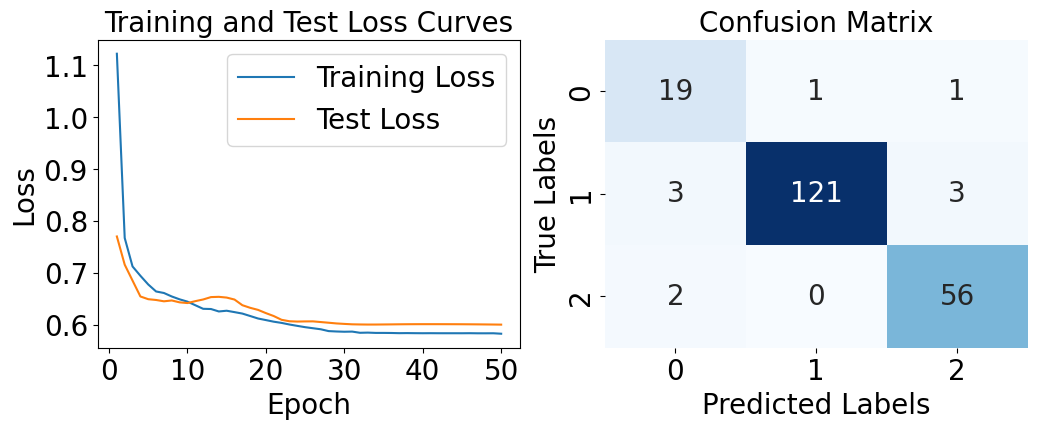

Training complete!


In [18]:
# Step 7: Training the Neural Network with Test Printing
print("Step 7: Training the Neural Network with Test Printing")

def train_and_plot_model(EPOCHS, model, X_train, y_train, X_test, y_test, optimizer):
    # Initialize lists to store training and test metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in range(EPOCHS):
        # Training
        model.train()  # Set the model to training mode
        optimizer.zero_grad()
        outputs = model(X_train)
        train_loss = loss_fn(outputs, y_train)
        train_loss.backward()
        optimizer.step()

        train_accuracy = accuracy_fn(y_train, outputs)

        # Testing
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            test_outputs = model(X_test)
            _, predicted = torch.max(test_outputs, 1)# go from logits -> prediction probabilities -> prediction labels
            test_loss = loss_fn(test_outputs, y_test)
            test_accuracy = accuracy_fn(y_test, test_outputs)

        # Log metrics
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)


        # Print the training and testing information
        if epoch < 10 or (epoch+1) % 10 == 0:
            print(f'Epoch: {epoch+1} | Loss: {train_loss.item():.5f}, Acc: {train_accuracy * 100:.2f}% | Test Loss: {test_loss.item():.5f}, Test Acc: {test_accuracy * 100:.2f}%')
        
    return model, (train_losses, test_losses, train_accuracies, test_accuracies, predicted)

def plot_learning_curves(train_losses, test_losses, train_accuracies, test_accuracies, y_prediction, y_test):
    # Plot Learning Curves
    plt.figure(figsize=(12, 4))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
    plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.legend(fontsize=20)
    plt.title('Training and Test Loss Curves', fontsize=20)

    conf_matrix = confusion_matrix(y_test, y_prediction)
    # Visualize Confusion Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size":20})
    plt.xlabel('Predicted Labels', fontsize=20)
    plt.ylabel('True Labels', fontsize=20)
    plt.title('Confusion Matrix', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.show()

    """# Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, EPOCHS + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Test Accuracy Curves')

    plt.tight_layout()
    plt.show()"""

    print("Training complete!")

model, loss_acc_5tuple = train_and_plot_model(EPOCHS, model, X_train, y_train, X_test, y_test, optimizer)

plot_learning_curves(*loss_acc_5tuple, y_test)

Epoch: 1 | Loss: 1.12779, Acc: 20.92% | Test Loss: 0.75798, Test Acc: 78.64%
Epoch: 2 | Loss: 0.77268, Acc: 78.47% | Test Loss: 0.69866, Test Acc: 84.95%
Epoch: 3 | Loss: 0.71833, Acc: 83.33% | Test Loss: 0.68512, Test Acc: 85.44%
Epoch: 4 | Loss: 0.68596, Acc: 86.25% | Test Loss: 0.67580, Test Acc: 86.89%
Epoch: 5 | Loss: 0.67545, Acc: 87.35% | Test Loss: 0.68104, Test Acc: 85.92%
Epoch: 6 | Loss: 0.66946, Acc: 88.20% | Test Loss: 0.67598, Test Acc: 86.89%
Epoch: 7 | Loss: 0.66397, Acc: 88.44% | Test Loss: 0.67047, Test Acc: 87.86%
Epoch: 8 | Loss: 0.65917, Acc: 88.81% | Test Loss: 0.67101, Test Acc: 87.38%
Epoch: 9 | Loss: 0.65295, Acc: 89.66% | Test Loss: 0.66826, Test Acc: 87.86%
Epoch: 10 | Loss: 0.64917, Acc: 90.27% | Test Loss: 0.66656, Test Acc: 87.86%
Epoch: 20 | Loss: 0.62825, Acc: 92.09% | Test Loss: 0.63691, Test Acc: 91.26%
Epoch: 30 | Loss: 0.60488, Acc: 94.77% | Test Loss: 0.61147, Test Acc: 94.17%
Epoch: 40 | Loss: 0.59639, Acc: 95.50% | Test Loss: 0.60499, Test Acc: 94

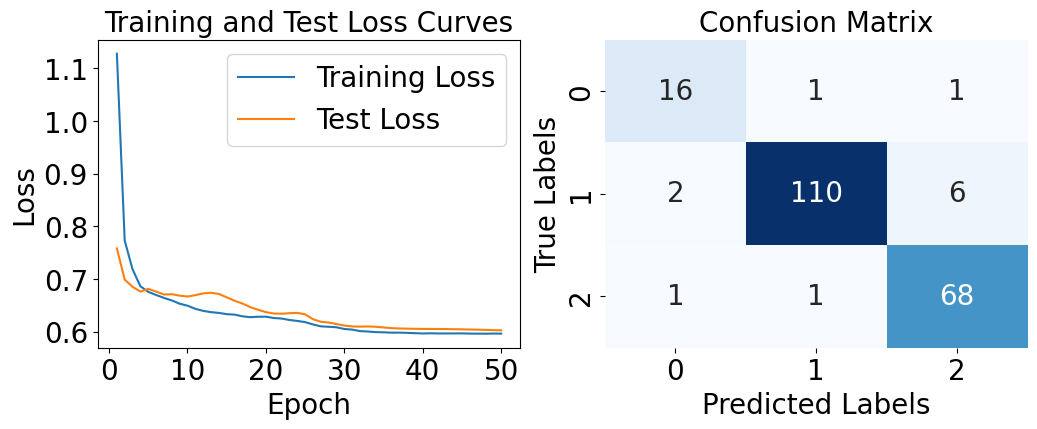

Training complete!
Test Accuracy: 94.17%
Precision = 0.9417, Recall = 0.9417, F1 = 0.9417
Class 0: Precision = 0.8421, Recall = 0.8889, F1 = 0.8649
Class 1: Precision = 0.9821, Recall = 0.9322, F1 = 0.9565
Class 2: Precision = 0.9067, Recall = 0.9714, F1 = 0.9379

Epoch: 1 | Loss: 1.12503, Acc: 23.48% | Test Loss: 0.72866, Test Acc: 84.95%
Epoch: 2 | Loss: 0.73521, Acc: 83.21% | Test Loss: 0.67513, Test Acc: 88.83%
Epoch: 3 | Loss: 0.68669, Acc: 86.13% | Test Loss: 0.66844, Test Acc: 88.83%
Epoch: 4 | Loss: 0.66599, Acc: 87.96% | Test Loss: 0.66899, Test Acc: 87.86%
Epoch: 5 | Loss: 0.65120, Acc: 90.51% | Test Loss: 0.66592, Test Acc: 87.38%
Epoch: 6 | Loss: 0.64458, Acc: 90.63% | Test Loss: 0.66110, Test Acc: 88.35%
Epoch: 7 | Loss: 0.63837, Acc: 91.24% | Test Loss: 0.65406, Test Acc: 89.81%
Epoch: 8 | Loss: 0.63314, Acc: 91.85% | Test Loss: 0.64836, Test Acc: 90.29%
Epoch: 9 | Loss: 0.62887, Acc: 92.09% | Test Loss: 0.64265, Test Acc: 90.78%
Epoch: 10 | Loss: 0.62478, Acc: 92.58% | T

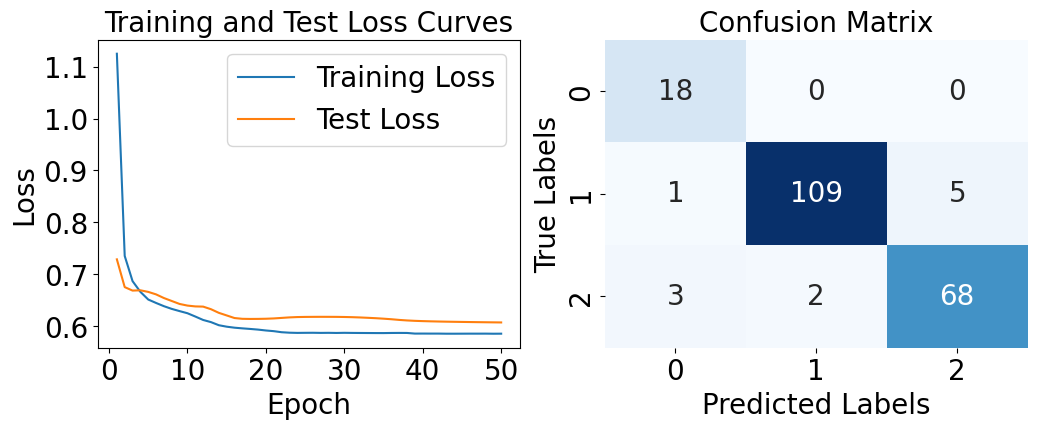

Training complete!
Test Accuracy: 94.66%
Precision = 0.9466, Recall = 0.9466, F1 = 0.9466
Class 0: Precision = 0.8182, Recall = 1.0000, F1 = 0.9000
Class 1: Precision = 0.9820, Recall = 0.9478, F1 = 0.9646
Class 2: Precision = 0.9315, Recall = 0.9315, F1 = 0.9315

Epoch: 1 | Loss: 1.10066, Acc: 31.75% | Test Loss: 0.78703, Test Acc: 79.61%
Epoch: 2 | Loss: 0.78369, Acc: 76.64% | Test Loss: 0.69992, Test Acc: 85.44%
Epoch: 3 | Loss: 0.71009, Acc: 83.82% | Test Loss: 0.67926, Test Acc: 86.89%
Epoch: 4 | Loss: 0.68674, Acc: 85.64% | Test Loss: 0.65994, Test Acc: 88.35%
Epoch: 5 | Loss: 0.66587, Acc: 87.83% | Test Loss: 0.63853, Test Acc: 90.78%
Epoch: 6 | Loss: 0.65332, Acc: 89.78% | Test Loss: 0.63452, Test Acc: 91.26%
Epoch: 7 | Loss: 0.65203, Acc: 89.90% | Test Loss: 0.63381, Test Acc: 91.75%
Epoch: 8 | Loss: 0.65140, Acc: 90.27% | Test Loss: 0.63038, Test Acc: 92.23%
Epoch: 9 | Loss: 0.64792, Acc: 90.39% | Test Loss: 0.62329, Test Acc: 92.72%
Epoch: 10 | Loss: 0.64155, Acc: 91.24% | T

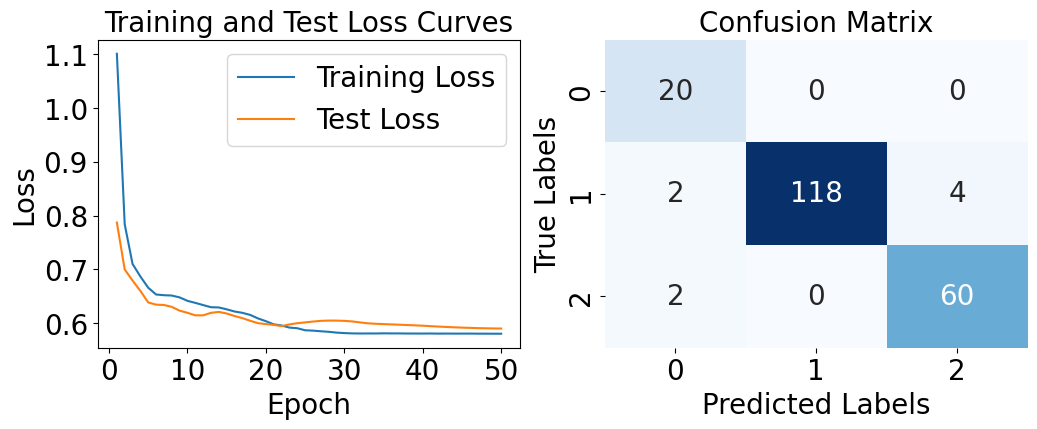

Training complete!
Test Accuracy: 96.12%
Precision = 0.9612, Recall = 0.9612, F1 = 0.9612
Class 0: Precision = 0.8333, Recall = 1.0000, F1 = 0.9091
Class 1: Precision = 1.0000, Recall = 0.9516, F1 = 0.9752
Class 2: Precision = 0.9375, Recall = 0.9677, F1 = 0.9524

Epoch: 1 | Loss: 1.13105, Acc: 22.26% | Test Loss: 0.79326, Test Acc: 75.24%
Epoch: 2 | Loss: 0.82111, Acc: 73.11% | Test Loss: 0.68816, Test Acc: 87.38%
Epoch: 3 | Loss: 0.71899, Acc: 82.48% | Test Loss: 0.68773, Test Acc: 85.44%
Epoch: 4 | Loss: 0.70035, Acc: 84.67% | Test Loss: 0.67357, Test Acc: 87.86%
Epoch: 5 | Loss: 0.68080, Acc: 86.98% | Test Loss: 0.66760, Test Acc: 87.86%
Epoch: 6 | Loss: 0.67042, Acc: 87.83% | Test Loss: 0.67019, Test Acc: 87.38%
Epoch: 7 | Loss: 0.66358, Acc: 88.81% | Test Loss: 0.66942, Test Acc: 87.86%
Epoch: 8 | Loss: 0.66010, Acc: 89.05% | Test Loss: 0.66869, Test Acc: 87.86%
Epoch: 9 | Loss: 0.65593, Acc: 89.42% | Test Loss: 0.66730, Test Acc: 87.86%
Epoch: 10 | Loss: 0.65136, Acc: 89.78% | T

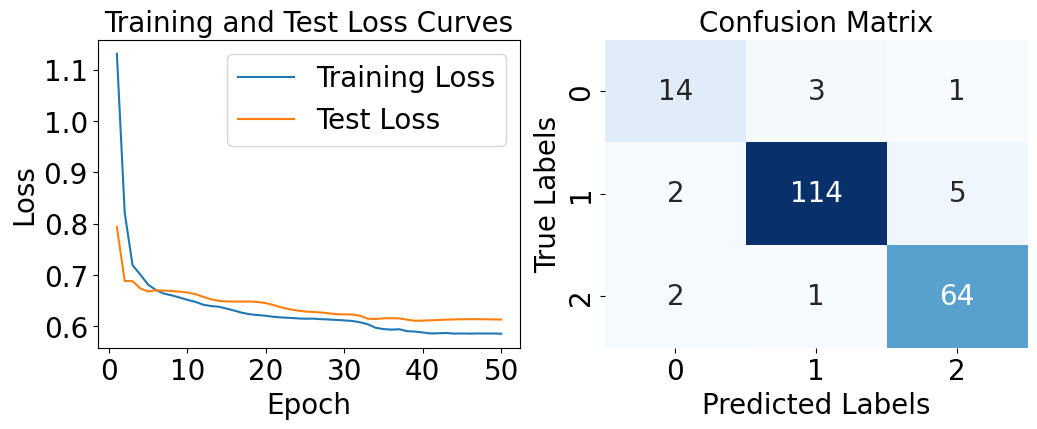

Training complete!
Test Accuracy: 93.20%
Precision = 0.9320, Recall = 0.9320, F1 = 0.9320
Class 0: Precision = 0.7778, Recall = 0.7778, F1 = 0.7778
Class 1: Precision = 0.9661, Recall = 0.9421, F1 = 0.9540
Class 2: Precision = 0.9143, Recall = 0.9552, F1 = 0.9343

Epoch: 1 | Loss: 1.10255, Acc: 32.97% | Test Loss: 0.76469, Test Acc: 79.61%
Epoch: 2 | Loss: 0.75685, Acc: 79.81% | Test Loss: 0.72714, Test Acc: 82.52%
Epoch: 3 | Loss: 0.70654, Acc: 83.70% | Test Loss: 0.71103, Test Acc: 83.50%
Epoch: 4 | Loss: 0.68744, Acc: 85.52% | Test Loss: 0.69823, Test Acc: 84.95%
Epoch: 5 | Loss: 0.66805, Acc: 88.20% | Test Loss: 0.69302, Test Acc: 85.44%
Epoch: 6 | Loss: 0.65459, Acc: 89.42% | Test Loss: 0.69148, Test Acc: 85.44%
Epoch: 7 | Loss: 0.65443, Acc: 89.54% | Test Loss: 0.68963, Test Acc: 85.44%
Epoch: 8 | Loss: 0.65100, Acc: 89.90% | Test Loss: 0.68607, Test Acc: 85.92%
Epoch: 9 | Loss: 0.64268, Acc: 90.63% | Test Loss: 0.68151, Test Acc: 86.89%
Epoch: 10 | Loss: 0.63459, Acc: 91.73% | T

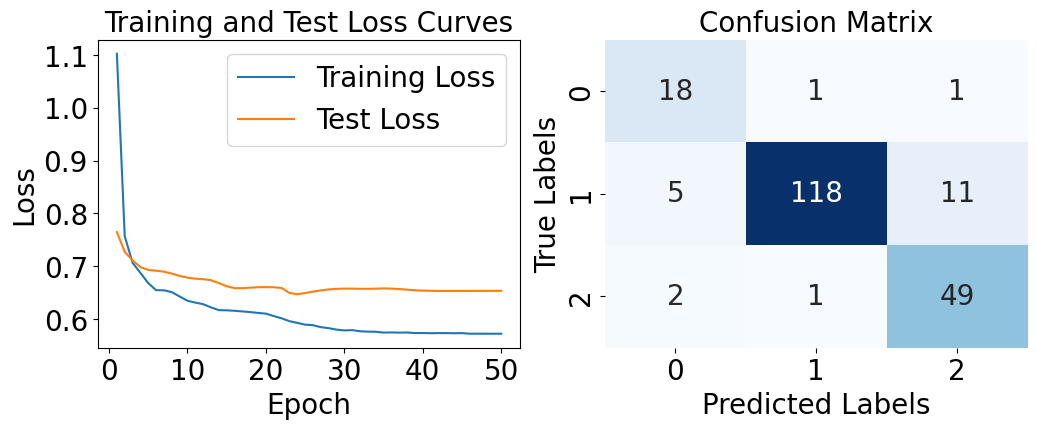

Training complete!
Test Accuracy: 89.81%
Precision = 0.8981, Recall = 0.8981, F1 = 0.8981
Class 0: Precision = 0.7200, Recall = 0.9000, F1 = 0.8000
Class 1: Precision = 0.9833, Recall = 0.8806, F1 = 0.9291
Class 2: Precision = 0.8033, Recall = 0.9423, F1 = 0.8673

Epoch: 1 | Loss: 1.10462, Acc: 29.56% | Test Loss: 0.79061, Test Acc: 76.70%
Epoch: 2 | Loss: 0.73782, Acc: 81.51% | Test Loss: 0.74692, Test Acc: 79.61%
Epoch: 3 | Loss: 0.70845, Acc: 84.06% | Test Loss: 0.72727, Test Acc: 83.01%
Epoch: 4 | Loss: 0.69239, Acc: 85.52% | Test Loss: 0.71182, Test Acc: 83.98%
Epoch: 5 | Loss: 0.67049, Acc: 87.71% | Test Loss: 0.70061, Test Acc: 83.98%
Epoch: 6 | Loss: 0.65377, Acc: 89.66% | Test Loss: 0.69342, Test Acc: 85.92%
Epoch: 7 | Loss: 0.64184, Acc: 90.63% | Test Loss: 0.69330, Test Acc: 85.44%
Epoch: 8 | Loss: 0.62777, Acc: 92.34% | Test Loss: 0.69273, Test Acc: 85.44%
Epoch: 9 | Loss: 0.62647, Acc: 92.21% | Test Loss: 0.69124, Test Acc: 85.92%
Epoch: 10 | Loss: 0.61982, Acc: 93.07% | T

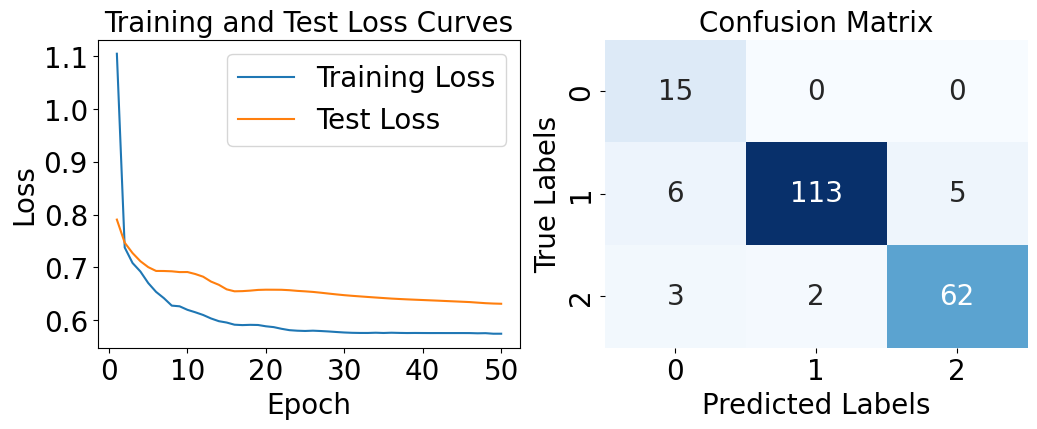

Training complete!
Test Accuracy: 92.23%
Precision = 0.9223, Recall = 0.9223, F1 = 0.9223
Class 0: Precision = 0.6250, Recall = 1.0000, F1 = 0.7692
Class 1: Precision = 0.9826, Recall = 0.9113, F1 = 0.9456
Class 2: Precision = 0.9254, Recall = 0.9254, F1 = 0.9254

Epoch: 1 | Loss: 1.10062, Acc: 34.18% | Test Loss: 0.78215, Test Acc: 78.16%
Epoch: 2 | Loss: 0.77963, Acc: 77.01% | Test Loss: 0.74534, Test Acc: 80.58%
Epoch: 3 | Loss: 0.72714, Acc: 82.00% | Test Loss: 0.72362, Test Acc: 83.01%
Epoch: 4 | Loss: 0.70596, Acc: 84.06% | Test Loss: 0.69800, Test Acc: 84.95%
Epoch: 5 | Loss: 0.68047, Acc: 86.62% | Test Loss: 0.68336, Test Acc: 85.92%
Epoch: 6 | Loss: 0.65918, Acc: 89.17% | Test Loss: 0.66928, Test Acc: 87.86%
Epoch: 7 | Loss: 0.64831, Acc: 90.39% | Test Loss: 0.66011, Test Acc: 89.32%
Epoch: 8 | Loss: 0.64485, Acc: 90.39% | Test Loss: 0.65963, Test Acc: 89.32%
Epoch: 9 | Loss: 0.63937, Acc: 91.36% | Test Loss: 0.65864, Test Acc: 88.83%
Epoch: 10 | Loss: 0.63670, Acc: 91.36% | T

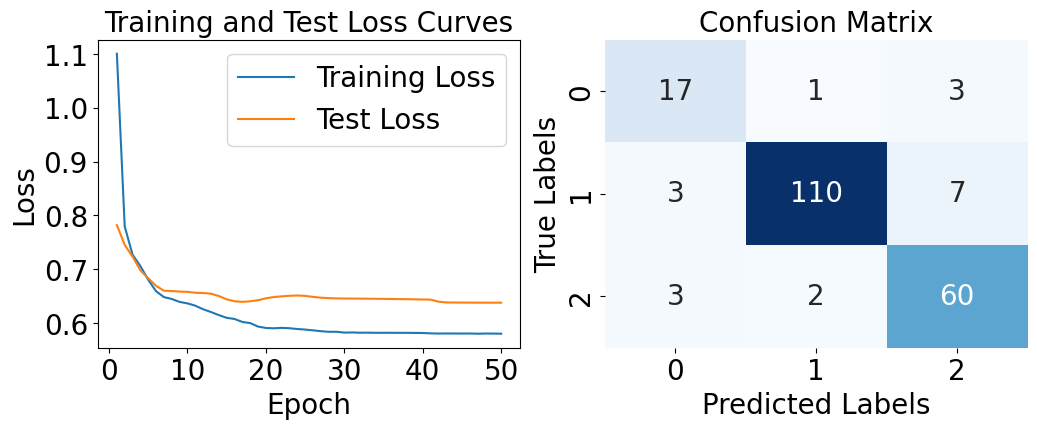

Training complete!
Test Accuracy: 90.78%
Precision = 0.9078, Recall = 0.9078, F1 = 0.9078
Class 0: Precision = 0.7391, Recall = 0.8095, F1 = 0.7727
Class 1: Precision = 0.9735, Recall = 0.9167, F1 = 0.9442
Class 2: Precision = 0.8571, Recall = 0.9231, F1 = 0.8889

Epoch: 1 | Loss: 1.12031, Acc: 22.26% | Test Loss: 0.75206, Test Acc: 79.13%
Epoch: 2 | Loss: 0.75524, Acc: 80.29% | Test Loss: 0.69226, Test Acc: 85.44%
Epoch: 3 | Loss: 0.68601, Acc: 86.74% | Test Loss: 0.67048, Test Acc: 86.89%
Epoch: 4 | Loss: 0.66664, Acc: 87.83% | Test Loss: 0.66827, Test Acc: 87.38%
Epoch: 5 | Loss: 0.65256, Acc: 89.54% | Test Loss: 0.66961, Test Acc: 87.86%
Epoch: 6 | Loss: 0.64179, Acc: 91.24% | Test Loss: 0.67142, Test Acc: 88.35%
Epoch: 7 | Loss: 0.63983, Acc: 91.24% | Test Loss: 0.67238, Test Acc: 87.86%
Epoch: 8 | Loss: 0.63431, Acc: 91.61% | Test Loss: 0.67330, Test Acc: 87.38%
Epoch: 9 | Loss: 0.62687, Acc: 92.34% | Test Loss: 0.67434, Test Acc: 87.86%
Epoch: 10 | Loss: 0.62314, Acc: 92.70% | T

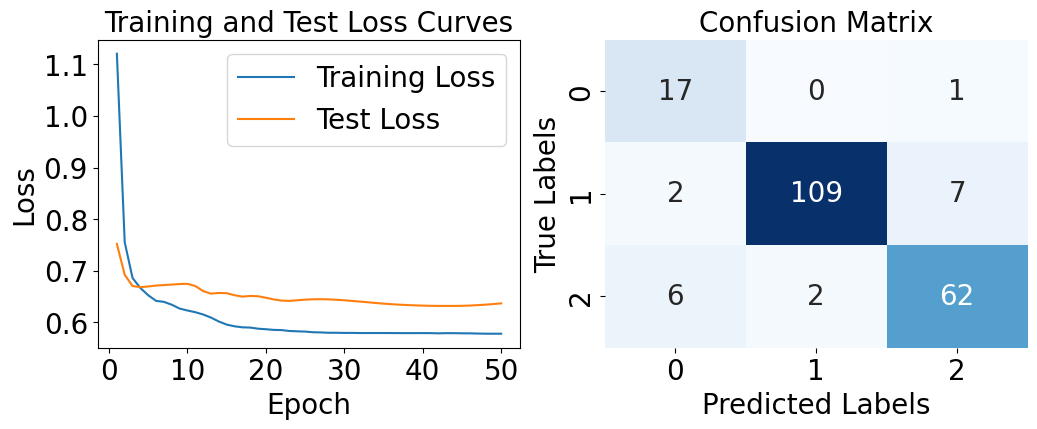

Training complete!
Test Accuracy: 91.26%
Precision = 0.9126, Recall = 0.9126, F1 = 0.9126
Class 0: Precision = 0.6800, Recall = 0.9444, F1 = 0.7907
Class 1: Precision = 0.9820, Recall = 0.9237, F1 = 0.9520
Class 2: Precision = 0.8857, Recall = 0.8857, F1 = 0.8857

Epoch: 1 | Loss: 1.10361, Acc: 32.00% | Test Loss: 0.79150, Test Acc: 76.70%
Epoch: 2 | Loss: 0.78846, Acc: 76.03% | Test Loss: 0.71531, Test Acc: 82.52%
Epoch: 3 | Loss: 0.72479, Acc: 81.87% | Test Loss: 0.70275, Test Acc: 84.95%
Epoch: 4 | Loss: 0.70413, Acc: 84.67% | Test Loss: 0.69108, Test Acc: 84.95%
Epoch: 5 | Loss: 0.68381, Acc: 86.74% | Test Loss: 0.67443, Test Acc: 87.38%
Epoch: 6 | Loss: 0.66891, Acc: 88.08% | Test Loss: 0.66490, Test Acc: 88.35%
Epoch: 7 | Loss: 0.65283, Acc: 89.90% | Test Loss: 0.66023, Test Acc: 89.32%
Epoch: 8 | Loss: 0.65142, Acc: 89.90% | Test Loss: 0.65502, Test Acc: 89.81%
Epoch: 9 | Loss: 0.64907, Acc: 90.15% | Test Loss: 0.64952, Test Acc: 90.78%
Epoch: 10 | Loss: 0.64474, Acc: 90.88% | T

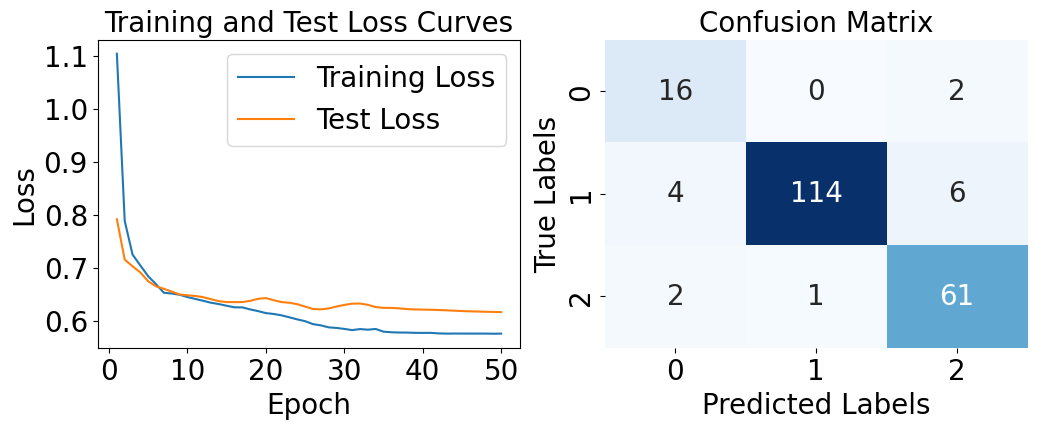

Training complete!
Test Accuracy: 92.72%
Precision = 0.9272, Recall = 0.9272, F1 = 0.9272
Class 0: Precision = 0.7273, Recall = 0.8889, F1 = 0.8000
Class 1: Precision = 0.9913, Recall = 0.9194, F1 = 0.9540
Class 2: Precision = 0.8841, Recall = 0.9531, F1 = 0.9173

Epoch: 1 | Loss: 1.10663, Acc: 29.32% | Test Loss: 0.81488, Test Acc: 73.30%
Epoch: 2 | Loss: 0.81133, Acc: 74.57% | Test Loss: 0.69741, Test Acc: 86.41%
Epoch: 3 | Loss: 0.71076, Acc: 83.70% | Test Loss: 0.69592, Test Acc: 84.95%
Epoch: 4 | Loss: 0.69180, Acc: 85.89% | Test Loss: 0.69363, Test Acc: 85.44%
Epoch: 5 | Loss: 0.68138, Acc: 86.74% | Test Loss: 0.68930, Test Acc: 84.95%
Epoch: 6 | Loss: 0.66835, Acc: 87.83% | Test Loss: 0.67355, Test Acc: 86.89%
Epoch: 7 | Loss: 0.65589, Acc: 89.17% | Test Loss: 0.65815, Test Acc: 89.32%
Epoch: 8 | Loss: 0.64860, Acc: 90.39% | Test Loss: 0.65714, Test Acc: 89.81%
Epoch: 9 | Loss: 0.64232, Acc: 91.00% | Test Loss: 0.66331, Test Acc: 88.35%
Epoch: 10 | Loss: 0.64019, Acc: 91.12% | T

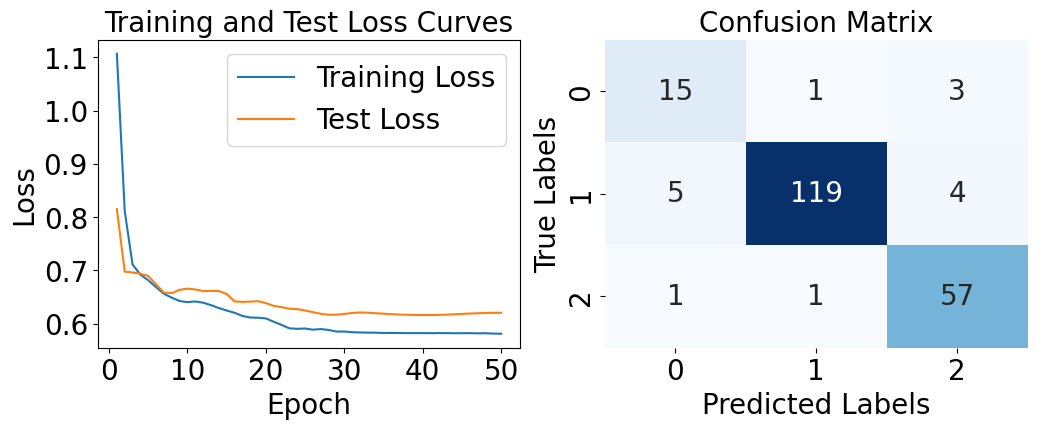

Training complete!
Test Accuracy: 92.72%
Precision = 0.9272, Recall = 0.9272, F1 = 0.9272
Class 0: Precision = 0.7143, Recall = 0.7895, F1 = 0.7500
Class 1: Precision = 0.9835, Recall = 0.9297, F1 = 0.9558
Class 2: Precision = 0.8906, Recall = 0.9661, F1 = 0.9268



In [ ]:
def execute_model_training(data, HIDDEN_UNITS, NUM_FEATURES, NUM_CLASSES, LR, EPOCHS, SEED, loss_fn):
    # Step 2 Splitting data & formatting to tensor
    X_train, X_test, y_train, y_test = split_data(data, normalize=True, seed=SEED)
    
    # Step 5: Initialize the Neural Network
    model = SimpleClassifier(NUM_FEATURES, HIDDEN_UNITS, NUM_CLASSES)

    # Step 6: Define Optimizer
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Step 7: Training the Neural Network with Test Printing
    model, loss_acc_4tuple = train_and_plot_model(EPOCHS, model, X_train, y_train, X_test, y_test, optimizer)

    plot_learning_curves(*loss_acc_4tuple, y_test)

    return model, X_test, y_test



#### test series for avarage results

f1_scores = []

# Step 1 Loading data if necessary
try:
    data                 # its ok that this var is not defined 
except NameError:
    data = load_data(0)

for seed in range(SEED, SEED+10):
    model, X_test, y_test = execute_model_training(
        data,
        HIDDEN_UNITS, 
        NUM_FEATURES, 
        NUM_CLASSES, 
        LR, 
        EPOCHS, 
        SEED, 
        loss_fn)

    # Evaluation (Forward pass) on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)

    
    # Calculate Precision and Recall avg over whole test vector
    precision = precision_score(y_test, predicted, average='weighted')
    recall = recall_score(y_test, predicted, average='weighted')
    f1 = f1_score(y_test, predicted, average='weighted')
    print(f'Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')
    f1_scores.append(f1)


    # Calculate Precision, Recall and f1 for each class
    precision = precision_score(y_test, predicted, average=None)
    recall = recall_score(y_test, predicted, average=None)
    f1 = f1_score(y_test, predicted, average=None)

    # Print statistics for each class
    for i, (prec, rec, f) in enumerate(zip(precision, recall, f1)):
        print(f'Class {i}: Precision = {prec:.4f}, Recall = {rec:.4f}, F1 = {f:.4f}')
    print()



from statistics import mean 

print(acc_list)
print(mean(acc_list))

Weighted F1 Score on Test Set: 0.9423


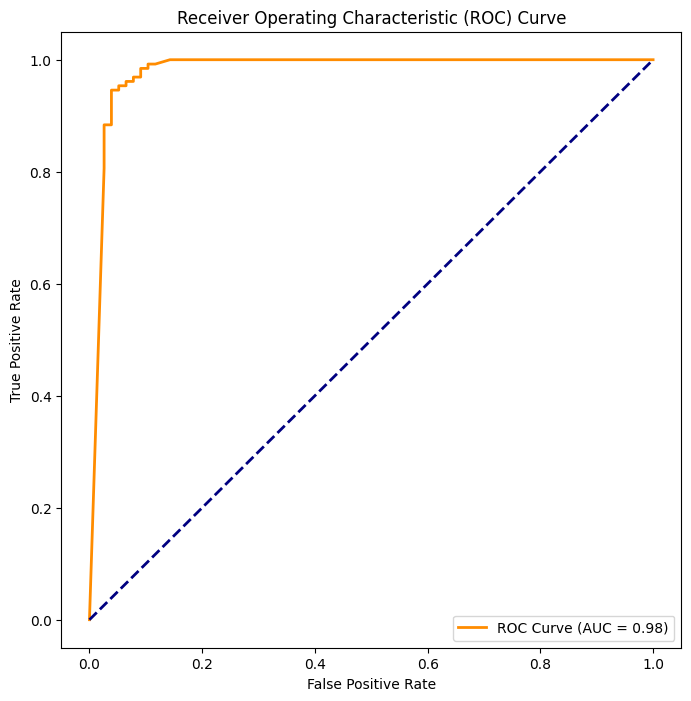

In [ ]:

model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted_labels = torch.max(test_outputs, 1)

f1 = f1_score(y_test, predicted_labels, average='weighted')
print(f'Weighted F1 Score on Test Set: {f1:.4f}')

# Plot ROC Curve
probs = torch.nn.functional.softmax(test_outputs, dim=1).numpy()
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
